In [77]:
import copy
import gc
import json
import os
from pathlib import Path
import sys
import time
import traceback
from typing import List, Tuple, Dict, Union, Optional
import warnings
import numpy as np
import torch
from anndata import AnnData
import scanpy as sc
import scvi
import numpy as npddddd
import wandb
from scipy.sparse import issparse
import matplotlib.pyplot as plt
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchtext.vocab import Vocab
from torchtext._torchtext import (
    Vocab as VocabPybind,
)

from Sophia import SophiaG 

from scgpt.tokenizer.gene_tokenizer import GeneVocab

sys.path.append("../")
import scgpt as scg
from scgpt.model import TransformerModel, AdversarialDiscriminator
from scgpt.tokenizer import tokenize_and_pad_batch, random_mask_value
from scgpt.loss import (
    masked_mse_loss,
    masked_relative_error,
    criterion_neg_log_bernoulli,
    masked_ce_loss
)
from scgpt.preprocess import Preprocessor
from scgpt import SubsetsBatchSampler
from scgpt.utils import set_seed, category_str2int, eval_scib_metrics

import mmsdistance

# from functions_group import DistanceLoss

sc.set_figure_params(figsize=(4, 4))
os.environ["KMP_WARNINGS"] = "off"
# os.environ["WANDB_MODE"] = "offline"

# hyperparameter_defaults = dict(
#     seed=42,
#     dataset_name="PBMC_10K",
#     do_train=True,
#     load_model="save/scGPT_bc",
#     mask_ratio=0.1,
#     epochs=10,
#     n_bins=10001,
#     GEPC=True,  # Masked value prediction for cell embedding
#     ecs_thres=0.8,  # Elastic cell similarity objective, 0.0 to 1.0, 0.0 to disable
#     dab_weight=10.0,
#     lr=1e-4,
#     batch_size=64,
#     layer_size=128,
#     nlayers=4,
#     nhead=4,
#     # if load model, batch_size, layer_size, nlayers, nhead will be ignored
#     dropout=0.2,
#     schedule_ratio=0.9,  # ratio of epochs for learning rate schedule
#     save_eval_interval=5,
#     log_interval=10,
#     fast_transformer=True,
#     pre_norm=False,
#     amp=True,  # Automatic Mixed Precision
# )

# modify original param
hyperparameter_defaults = dict(
    seed=42,
    dataset_name="PBMC_10K",
    do_train=True,
    load_model="save/scGPT_bc",
    mask_ratio=0.4,
    epochs=10,
    n_bins=51,
    GEPC=True,  # Masked value prediction for cell embedding
    ecs_thres=0.8,  # Elastic cell similarity objective, 0.0 to 1.0, 0.0 to disable
    dab_weight=1.0,
    lr=1e-4,
    batch_size=32,
    layer_size=128,
    nlayers=4,
    nhead=4,
    # if load model, batch_size, layer_size, nlayers, nhead will be ignored
    dropout=0.2,
    schedule_ratio=0.9,  # ratio of epochs for learning rate schedule
    save_eval_interval=5,
    log_interval=100,
    fast_transformer=True,
    pre_norm=False,
    amp=True,  # Automatic Mixed Precision
)

run = wandb.init(
    config=hyperparameter_defaults,
    project="scGPT",
    reinit=True,
    settings=wandb.Settings(start_method="fork"),
)
config = wandb.config
print(config)

/notebooks/lib/python3.9/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)
/notebooks/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:70: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


{'seed': 42, 'dataset_name': 'PBMC_10K', 'do_train': True, 'load_model': 'save/scGPT_bc', 'mask_ratio': 0.4, 'epochs': 10, 'n_bins': 51, 'GEPC': True, 'ecs_thres': 0.8, 'dab_weight': 1.0, 'lr': 0.0001, 'batch_size': 32, 'layer_size': 128, 'nlayers': 4, 'nhead': 4, 'dropout': 0.2, 'schedule_ratio': 0.9, 'save_eval_interval': 5, 'log_interval': 100, 'fast_transformer': True, 'pre_norm': False, 'amp': True}


In [78]:
def order_selection(adata, key='batch', orders=None):
    '''Function used to determine the training sequence based on the variance across genes.
        Args:
            adata: The given dataset in AnnData form
            key: The index name of batch information in the given dataset
            orders: The batch sequence for training or none
        Output:
            orders: The batch sequence for training
    '''
    if orders == None:
        batch_list = list(set(adata.obs[key].values))
        adata_values = [np.array(adata.X[adata.obs[key] == batch]) for batch in batch_list]
        std_ = [np.sum(np.std(item, axis=0)) for item in adata_values]
        orders = np.argsort(std_)[::-1]
        return [batch_list[i] for i in orders] 
    else:
        return orders

def generate_target_dataset(adata, batch_list):
    """A simple function used to rearrange the batch index of our given dataset.
    """
    adata0 = adata[adata.obs['batch'] == batch_list[0]]
    for i in batch_list[1:]:
        adata0 = adata0.concatenate(adata[adata.obs['batch'] == i], batch_key='batch_key', index_unique=None)
    return adata0

In [79]:
use_dataset = "HumanPBMC"

In [80]:
set_seed(config.seed)

# %%
# settings for input and preprocessing
pad_token = "<pad>"
special_tokens = [pad_token, "<cls>", "<eoc>"]
mask_ratio = config.mask_ratio
mask_value = -1
pad_value = -2
n_input_bins = config.n_bins

n_hvg = 2000  # number of highly variable genes
max_seq_len = n_hvg + 1
per_seq_batch_sample = False
DSBN = True  # Domain-spec batchnorm
explicit_zero_prob = True  # whether explicit bernoulli for zeros

# %%
dataset_name = config.dataset_name
save_dir = Path(f"./save/dev_{dataset_name}-{time.strftime('%b%d-%H-%M')}/")
save_dir.mkdir(parents=True, exist_ok=True)
print(f"save to {save_dir}")
# save the whole script to the dir
# os.system(f"cp {__file__} {save_dir}")

logger = scg.logger
scg.utils.add_file_handler(logger, save_dir / "run.log")


# %% [markdown]
# ## Loading and preparing data
# if dataset_name == "PBMC_10K":
#     adata = scvi.data.pbmc_dataset()  # 11990 × 3346
#     ori_batch_col = "batch"
#     adata.obs["celltype"] = adata.obs["str_labels"].astype("category")
#     adata.var = adata.var.set_index("gene_symbols")
#     data_is_raw = True



adata = sc.read_loom(f"./save/{use_dataset}_raw.loom")  # 11990 × 3346
# adata.var_names = [i.upper() for i in adata.var_names]

# adata = sc.read_h5ad(f"./save/{use_dataset}_raw.loom")  # 11990 × 3346

# adata = sc.read_h5ad(f"./save/{use_dataset}.h5ad")  # 11990 × 3346
adata = sc.AnnData(adata.X.todense(), obs = adata.obs, var = adata.var)
ori_batch_col = "batch"
adata.obs["celltype"] = adata.obs["celltype"].astype("category")
# adata.obs["celltype"] = list(adata.obs["final_annotation"])
adata.obs['celltype'] = adata.obs['celltype'].astype('category')

data_is_raw = True

order = order_selection(adata) 
adata = generate_target_dataset(adata, order)
# adata = adata[[True if i in ["Batch3_fluidigmc1", "Batch5_smartseq2"] else False for i in adata.obs.batch]]

# %%
# make the batch category column 
adata.obs["str_batch"] = adata.obs[ori_batch_col].astype(str)
batch_id_labels = adata.obs["str_batch"].astype("category").cat.codes.values
adata.obs["batch_id"] = batch_id_labels

adata.var["gene_name"] = adata.var.index.tolist()

if config.load_model is not None:
    model_dir = Path(config.load_model)
    model_config_file = model_dir / "args.json"
    model_file = model_dir / "best_model.pt"
    vocab_file = model_dir / "vocab.json"

    vocab = GeneVocab.from_file(vocab_file)
    for s in special_tokens:
        if s not in vocab:
            vocab.append_token(s)

    adata.var["id_in_vocab"] = [
        1 if gene in vocab else -1 for gene in adata.var["gene_name"]
    ]
    gene_ids_in_vocab = np.array(adata.var["id_in_vocab"])
    logger.info(
        f"match {np.sum(gene_ids_in_vocab >= 0)}/{len(gene_ids_in_vocab)} genes "
        f"in vocabulary of size {len(vocab)}."
    )
    adata = adata[:, adata.var["id_in_vocab"] >= 0]

    # model
    with open(model_config_file, "r") as f:
        model_configs = json.load(f)
    logger.info(
        f"Resume model from {model_file}, the model args will override the "
        f"config {model_config_file}."
    )
    embsize = model_configs["embsize"]
    nhead = model_configs["nheads"]
    d_hid = model_configs["d_hid"]
    nlayers = model_configs["nlayers"]
    n_layers_cls = model_configs["n_layers_cls"]


save to save/dev_PBMC_10K-Jul01-22-25


/notebooks/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


scGPT - INFO - match 18248/20378 genes in vocabulary of size 36574.
scGPT - INFO - Resume model from save/scGPT_bc/best_model.pt, the model args will override the config save/scGPT_bc/args.json.


In [81]:
adata

View of AnnData object with n_obs × n_vars = 15476 × 18248
    obs: 'batch', 'celltype', 'batch_key', 'str_batch', 'batch_id'
    var: 'gene_name', 'id_in_vocab'

In [82]:
# sc.tl.pca(adata)
# sc.pp.neighbors(adata)
# sc.tl.umap(adata)

In [83]:
# sc.pl.umap(adata, color='batch')

In [84]:
# %%
# set up the preprocessor, use the args to config the workflow
preprocessor = Preprocessor(
    use_key="X",  # the key in adata.layers to use as raw data
    filter_gene_by_counts=3,  # step 1
    filter_cell_by_counts=False,  # step 2
    normalize_total=1e4,  # 3. whether to normalize the raw data and to what sum
    result_normed_key="X_normed",  # the key in adata.layers to store the normalized data
    log1p=data_is_raw,  # 4. whether to log1p the normalized data
    result_log1p_key="X_log1p",
    subset_hvg=n_hvg,  # 5. whether to subset the raw data to highly variable genes
    hvg_flavor="seurat_v3" if data_is_raw else "cell_ranger",
    binning=config.n_bins,  # 6. whether to bin the raw data and to what number of bins
    result_binned_key="X_binned",  # the key in adata.layers to store the binned data
)
preprocessor(adata, batch_key="batch" if dataset_name != "heart_cell" else None)

# %%
if per_seq_batch_sample:
    # sort the adata by batch_id in advance
    adata_sorted = adata[adata.obs["batch_id"].argsort()].copy()

# %% [markdown]
# ## Tokenize input

# %%
input_layer_key = "X_binned"
all_counts = (
    adata.layers[input_layer_key].A
    if issparse(adata.layers[input_layer_key])
    else adata.layers[input_layer_key]
)
genes = adata.var["gene_name"].tolist()

celltypes_labels = adata.obs["celltype"].tolist()  # make sure count from 0
num_types = len(set(celltypes_labels))
celltypes_labels = np.array(celltypes_labels)

batch_ids = adata.obs["batch_id"].tolist()
num_batch_types = len(set(batch_ids))
batch_ids = np.array(batch_ids)

(
    train_data,
    valid_data,
    train_celltype_labels,
    valid_celltype_labels,
    train_batch_labels,
    valid_batch_labels,
) = train_test_split(
    all_counts, celltypes_labels, batch_ids, test_size=0.001, shuffle=True
)

# %%
if config.load_model is None:
    vocab = Vocab(
        VocabPybind(genes + special_tokens, None)
    )  # bidirectional lookup [gene <-> int]
vocab.set_default_index(vocab["<pad>"])
gene_ids = np.array(vocab(genes), dtype=int)

# %%
tokenized_train = tokenize_and_pad_batch(
    train_data,
    gene_ids,
    max_len=max_seq_len,
    vocab=vocab,
    pad_token=pad_token,
    pad_value=pad_value,
    append_cls=True,  # append <cls> token at the beginning
    include_zero_gene=True,
)
tokenized_valid = tokenize_and_pad_batch(
    valid_data,
    gene_ids,
    max_len=max_seq_len,
    vocab=vocab,
    pad_token=pad_token,
    pad_value=pad_value,
    append_cls=True,
    include_zero_gene=True,
)
logger.info(
    f"train set number of samples: {tokenized_train['genes'].shape[0]}, "
    f"\n\t feature length: {tokenized_train['genes'].shape[1]}"
)
logger.info(
    f"valid set number of samples: {tokenized_valid['genes'].shape[0]}, "
    f"\n\t feature length: {tokenized_valid['genes'].shape[1]}"
)


# %%
def prepare_data(sort_seq_batch=False) -> Tuple[Dict[str, torch.Tensor]]:
    masked_values_train = random_mask_value(
        tokenized_train["values"],
        mask_ratio=mask_ratio,
        mask_value=mask_value,
        pad_value=pad_value,
    )
    masked_values_valid = random_mask_value(
        tokenized_valid["values"],
        mask_ratio=mask_ratio,
        mask_value=mask_value,
        pad_value=pad_value,
    )
    print(
        f"random masking at epoch {epoch:3d}, ratio of masked values in train: ",
        f"{(masked_values_train == mask_value).sum() / (masked_values_train - pad_value).count_nonzero():.4f}",
    )

    input_gene_ids_train, input_gene_ids_valid = (
        tokenized_train["genes"],
        tokenized_valid["genes"],
    )
    input_values_train, input_values_valid = masked_values_train, masked_values_valid
    target_values_train, target_values_valid = (
        tokenized_train["values"],
        tokenized_valid["values"],
    )

    tensor_batch_labels_train = torch.from_numpy(train_batch_labels).long()
    tensor_batch_labels_valid = torch.from_numpy(valid_batch_labels).long()

    if sort_seq_batch:
        train_sort_ids = np.argsort(train_batch_labels)
        input_gene_ids_train = input_gene_ids_train[train_sort_ids]
        input_values_train = input_values_train[train_sort_ids]
        target_values_train = target_values_train[train_sort_ids]
        tensor_batch_labels_train = tensor_batch_labels_train[train_sort_ids]

        valid_sort_ids = np.argsort(valid_batch_labels)
        input_gene_ids_valid = input_gene_ids_valid[valid_sort_ids]
        input_values_valid = input_values_valid[valid_sort_ids]
        target_values_valid = target_values_valid[valid_sort_ids]
        tensor_batch_labels_valid = tensor_batch_labels_valid[valid_sort_ids]

    train_data_pt = {
        "gene_ids": input_gene_ids_train,
        "values": input_values_train,
        "target_values": target_values_train,
        "batch_labels": tensor_batch_labels_train,
    }
    valid_data_pt = {
        "gene_ids": input_gene_ids_valid,
        "values": input_values_valid,
        "target_values": target_values_valid,
        "batch_labels": tensor_batch_labels_valid,
    }

    return train_data_pt, valid_data_pt


# dataset
class SeqDataset(Dataset):
    def __init__(self, data: Dict[str, torch.Tensor]):
        self.data = data

    def __len__(self):
        return self.data["gene_ids"].shape[0]

    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.data.items()}


# data_loader
def prepare_dataloader(
    data_pt: Dict[str, torch.Tensor],
    batch_size: int,
    shuffle: bool = False,
    intra_domain_shuffle: bool = False,
    drop_last: bool = False,
    num_workers: int = 0,
) -> DataLoader:
    dataset = SeqDataset(data_pt)

    if per_seq_batch_sample:
        # find the indices of samples in each seq batch
        subsets = []
        batch_labels_array = data_pt["batch_labels"].numpy()
        for batch_label in np.unique(batch_labels_array):
            batch_indices = np.where(batch_labels_array == batch_label)[0].tolist()
            subsets.append(batch_indices)
        data_loader = DataLoader(
            dataset=dataset,
            batch_sampler=SubsetsBatchSampler(
                subsets,
                batch_size,
                intra_subset_shuffle=intra_domain_shuffle,
                inter_subset_shuffle=shuffle,
                drop_last=drop_last,
            ),
            num_workers=num_workers,
            pin_memory=True,
        )
        return data_loader

    data_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,
    )
    return data_loader

scGPT - INFO - Filtering genes by counts ...


/notebooks/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:249: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_counts'] = number


scGPT - INFO - Filtering cells by counts ...
scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Log1p transforming ...
scGPT - INFO - Subsetting highly variable genes ...
scGPT - INFO - Binning data ...
scGPT - INFO - train set number of samples: 15460, 
	 feature length: 2001
scGPT - INFO - valid set number of samples: 16, 
	 feature length: 2001


In [85]:
# %% [markdown]
# # Create and finetune scGPT

# %%
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ntokens = len(vocab)  # size of vocabulary
model = TransformerModel(
    ntokens,
    embsize,
    nhead,
    d_hid,
    nlayers,
    vocab=vocab,
    dropout=config.dropout,
    pad_token=pad_token,
    pad_value=pad_value,
    do_mvc=config.GEPC,
    do_dab=True,
    use_batch_labels=True,
    num_batch_labels=num_batch_types,
    domain_spec_batchnorm=DSBN,
    n_input_bins=n_input_bins,
    ecs_threshold=config.ecs_thres,
    explicit_zero_prob=explicit_zero_prob,
    use_fast_transformer=True,
    pre_norm=config.pre_norm,
)
if config.load_model is not None:
    try:
        model.load_state_dict(torch.load(model_file))
        logger.info(f"Loading all model params from {model_file}")
    except:
        # only load params that are in the model and match the size
        model_dict = model.state_dict()
        pretrained_dict = torch.load(model_file)
        pretrained_dict = {
            k: v
            for k, v in pretrained_dict.items()
            if k in model_dict and v.shape == model_dict[k].shape
        }
        for k, v in pretrained_dict.items():
            logger.info(f"Loading params {k} with shape {v.shape}")
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict)

model.to(device)
# wandb.watch(model)


# criterion = masked_mse_loss
criterion = masked_ce_loss


criterion_dab = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(
#     model.parameters(), lr=config.lr,
# )

optimizer = torch.optim.Adam(
    model.parameters(), lr=config.lr, eps=1e-4 if config.amp else 1e-8
)

# optimizer = SophiaG(model.parameters(), lr=config.lr, betas=(0.965, 0.99), rho = 0.01, weight_decay=1e-1)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=config.schedule_ratio)

scaler = torch.cuda.amp.GradScaler(enabled=config.amp)

Use domain specific batchnorm with affine=False
scGPT - INFO - Loading params encoder.embedding.weight with shape torch.Size([36574, 512])
scGPT - INFO - Loading params encoder.enc_norm.weight with shape torch.Size([512])
scGPT - INFO - Loading params encoder.enc_norm.bias with shape torch.Size([512])
scGPT - INFO - Loading params value_encoder.linear1.weight with shape torch.Size([512, 1])
scGPT - INFO - Loading params value_encoder.linear1.bias with shape torch.Size([512])
scGPT - INFO - Loading params value_encoder.linear2.weight with shape torch.Size([512, 512])
scGPT - INFO - Loading params value_encoder.linear2.bias with shape torch.Size([512])
scGPT - INFO - Loading params value_encoder.norm.weight with shape torch.Size([512])
scGPT - INFO - Loading params value_encoder.norm.bias with shape torch.Size([512])
scGPT - INFO - Loading params transformer_encoder.layers.0.self_attn.Wqkv.weight with shape torch.Size([1536, 512])
scGPT - INFO - Loading params transformer_encoder.layers.

In [86]:
# for param in model.parameters():
#     param.requires_grad = False
# for param in model.transformer_encoder.parameters():
#     param.requires_grad = True
    
# for param in model.decoder.parameters():
#     param.requires_grad = True

In [87]:
model

TransformerModel(
  (encoder): GeneEncoder(
    (embedding): Embedding(36574, 512, padding_idx=36571)
    (enc_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (value_encoder): ContinuousValueEncoder(
    (dropout): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=1, out_features=512, bias=True)
    (activation): ReLU()
    (linear2): Linear(in_features=512, out_features=512, bias=True)
    (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (batch_encoder): BatchLabelEncoder(
    (embedding): Embedding(2, 512)
    (enc_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (dsbn): DomainSpecificBatchNorm1d(
    (bns): ModuleList(
      (0): BatchNorm1d(512, eps=6.1e-05, momentum=0.1, affine=False, track_running_stats=True)
      (1): BatchNorm1d(512, eps=6.1e-05, momentum=0.1, affine=False, track_running_stats=True)
    )
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): FlashTransformerEn

In [88]:

def train(model: nn.Module, loader: DataLoader) -> None:
    """
    Train the model for one epoch.
    """
    model.train()
    total_loss, total_mse, total_gepc = 0.0, 0.0, 0.0
    total_error = 0.0
    log_interval = config.log_interval
    start_time = time.time()

    num_batches = len(loader)
    for batch, batch_data in enumerate(loader):
        input_gene_ids = batch_data["gene_ids"].to(device)
        input_values = batch_data["values"].to(device)
        target_values = batch_data["target_values"].to(device)
        batch_labels = batch_data["batch_labels"].to(device)
        
        src_key_padding_mask = input_gene_ids.eq(vocab[pad_token])
        with torch.cuda.amp.autocast(enabled=config.amp):
            output_dict = model(
                input_gene_ids,
                input_values,
                src_key_padding_mask=src_key_padding_mask,
                batch_labels=batch_labels if DSBN else None,
                MVC=config.GEPC,
                ECS=config.ecs_thres > 0,
            )

            masked_positions = input_values.eq(mask_value)  # the postions to predict
            loss = loss_mse = criterion(
                output_dict["mlm_output"], target_values, masked_positions
            )
            
            
            # loss = loss_mse = torch.FloatTensor([0.0]).cuda()
            
            metrics_to_log = {"train/mse": loss_mse.item()}
            
            if explicit_zero_prob:
                loss_zero_log_prob = criterion_neg_log_bernoulli(
                    output_dict["mlm_zero_probs"], target_values, masked_positions
                )
                loss = loss + loss_zero_log_prob
                metrics_to_log.update({"train/nzlp": loss_zero_log_prob.item()})
                
            if config.GEPC:
                loss_gepc = criterion(
                    output_dict["mvc_output"], target_values, masked_positions
                )
                loss = loss + loss_gepc
                metrics_to_log.update({"train/mvc": loss_gepc.item()})
                
            if config.GEPC and explicit_zero_prob:
                loss_gepc_zero_log_prob = criterion_neg_log_bernoulli(
                    output_dict["mvc_zero_probs"], target_values, masked_positions
                )
                loss = loss + loss_gepc_zero_log_prob
                metrics_to_log.update(
                    {"train/mvc_nzlp": loss_gepc_zero_log_prob.item()}
                )
                
            if config.ecs_thres > 0:
                loss_ecs = 10 * output_dict["loss_ecs"]
                loss = loss + loss_ecs
                metrics_to_log.update({"train/ecs": loss_ecs.item()})
                
                
#             loss_gepc = torch.FloatTensor([0.0])
            
            loss_dab = criterion_dab(output_dict["dab_output"], batch_labels)
            loss = loss + config.dab_weight * loss_dab
            # loss_dab = torch.FloatTensor([0.0])
            metrics_to_log.update({"train/dab": loss_dab.item()})

        model.zero_grad()
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        with warnings.catch_warnings(record=True) as w:
            warnings.filterwarnings("always")
            torch.nn.utils.clip_grad_norm_(
                model.parameters(),
                1.0,
                error_if_nonfinite=False if scaler.is_enabled() else True,
            )
            if len(w) > 0:
                logger.warning(
                    f"Found infinite gradient. This may be caused by the gradient "
                    f"scaler. The current scale is {scaler.get_scale()}. This warning "
                    "can be ignored if no longer occurs after autoscaling of the scaler."
                )
        scaler.step(optimizer)
        scaler.update()

        wandb.log(metrics_to_log)

        with torch.no_grad():
            mre = masked_relative_error(
                output_dict["mlm_output"], target_values, masked_positions
            )

        total_loss += loss.item()
        total_mse += loss_mse.item()
        total_gepc += loss_gepc.item() if config.GEPC else 0.0
        total_error += mre.item()
        if batch % log_interval == 0 and batch > 0:
            lr = scheduler.get_last_lr()[0]
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = total_loss / log_interval
            cur_mse = total_mse / log_interval
            cur_gepc = total_gepc / log_interval if config.GEPC else 0.0
            cur_error = total_error / log_interval
            # ppl = math.exp(cur_loss)
            logger.info(
                f"| epoch {epoch:3d} | {batch:3d}/{num_batches:3d} batches | "
                f"lr {lr:05.4f} | ms/batch {ms_per_batch:5.2f} | "
                f"loss {cur_loss:5.2f} | mse {cur_mse:5.2f} | mre {cur_error:5.2f} |"
                + (f"gepc {cur_gepc:5.2f} |" if config.GEPC else "")
            )
            total_loss = 0
            total_mse = 0
            total_gepc = 0
            total_error = 0
            start_time = time.time()


def define_wandb_metrcis():
    wandb.define_metric("valid/mse", summary="min", step_metric="epoch")
    wandb.define_metric("valid/mre", summary="min", step_metric="epoch")
    wandb.define_metric("valid/dab", summary="min", step_metric="epoch")
    wandb.define_metric("valid/sum_mse_dab", summary="min", step_metric="epoch")
    wandb.define_metric("test/avg_bio", summary="max")


def evaluate(model: nn.Module, loader: DataLoader) -> float:
    """
    Evaluate the model on the evaluation data.
    """
    model.eval()
    total_loss = 0.0
    total_error = 0.0
    total_dab = 0.0
    total_num = 0
    with torch.no_grad():
        for batch_data in loader:
            input_gene_ids = batch_data["gene_ids"].to(device)
            input_values = batch_data["values"].to(device)
            target_values = batch_data["target_values"].to(device)
            batch_labels = batch_data["batch_labels"].to(device)

            src_key_padding_mask = input_gene_ids.eq(vocab[pad_token])
            with torch.cuda.amp.autocast(enabled=config.amp):
                output_dict = model(
                    input_gene_ids,
                    input_values,
                    src_key_padding_mask=src_key_padding_mask,
                    batch_labels=batch_labels if DSBN else None,
                )
                output_values = output_dict["mlm_output"]

                masked_positions = input_values.eq(mask_value)
                loss = criterion(output_values, target_values, masked_positions)
                loss_dab = criterion_dab(output_dict["dab_output"], batch_labels)

            total_loss += loss.item() * len(input_gene_ids)
            total_error += masked_relative_error(
                output_values, target_values, masked_positions
            ).item() * len(input_gene_ids)
            total_dab += loss_dab.item() * len(input_gene_ids)
            total_num += len(input_gene_ids)

    wandb.log(
        {
            "valid/mse": total_loss / total_num,
            "valid/mre": total_error / total_num,
            "valid/dab": total_dab / total_num,
            "valid/sum_mse_dab": (total_loss + config.dab_weight * total_dab)
            / total_num,
            "epoch": epoch,
        },
    )

    return total_loss / total_num, total_error / total_num


def eval_testdata(
    model: nn.Module,
    adata_t: AnnData,
    include_types: List[str] = ["cls"],
) -> Optional[Dict]:
    """evaluate the model on test dataset of adata_t"""
    model.eval()

    # copy adata_t to avoid reuse previously computed results stored in adata_t
    adata_t = adata_t.copy()

    all_counts = (
        adata_t.layers[input_layer_key].A
        if issparse(adata_t.layers[input_layer_key])
        else adata_t.layers[input_layer_key]
    )

    celltypes_labels = adata_t.obs["celltype"].tolist()
    celltypes_labels = np.array(celltypes_labels)

    batch_ids = adata_t.obs["batch_id"].tolist()
    batch_ids = np.array(batch_ids)

    # Evaluate cls cell embeddings
    if "cls" in include_types:
        logger.info("Evaluating cls cell embeddings")
        tokenized_all = tokenize_and_pad_batch(
            all_counts,
            gene_ids,
            max_len=max_seq_len,
            vocab=vocab,
            pad_token=pad_token,
            pad_value=pad_value,
            append_cls=True,  # append <cls> token at the beginning
            include_zero_gene=True,
        )
        all_gene_ids, all_values = tokenized_all["genes"], tokenized_all["values"]
        src_key_padding_mask = all_gene_ids.eq(vocab[pad_token])
        with torch.no_grad(), torch.cuda.amp.autocast(enabled=config.amp):
            cell_embeddings = model.encode_batch(
                all_gene_ids,
                all_values.float(),
                src_key_padding_mask=src_key_padding_mask,
                batch_size=config.batch_size,
                batch_labels=torch.from_numpy(batch_ids).long() if DSBN else None,
                time_step=0,
                return_np=True,
            )
        cell_embeddings = cell_embeddings / np.linalg.norm(
            cell_embeddings, axis=1, keepdims=True
        )

        adata_t.obsm["X_scGPT"] = cell_embeddings

        results = {}
        try:
            results = eval_scib_metrics(adata_t)
        except Exception as e:
            traceback.print_exc()
            logger.error(e)

        sc.pp.neighbors(adata_t, use_rep="X_scGPT")
        sc.tl.umap(adata_t, min_dist=0.3)
        fig = sc.pl.umap(
            adata_t,
            color=["str_batch"],
            title=[f"batch, avg_bio = {results.get('avg_bio', 0.0):.4f}"],
            frameon=False,
            return_fig=True,
            show=False,
        )

        results["batch_umap"] = fig

        sc.pp.neighbors(adata_t, use_rep="X_scGPT")
        sc.tl.umap(adata_t, min_dist=0.3)
        fig = sc.pl.umap(
            adata_t,
            color=["celltype"],
            title=[
                f"celltype, avg_bio = {results.get('avg_bio', 0.0):.4f}",
            ],
            frameon=False,
            return_fig=True,
            show=False,
        )

        results["celltype_umap"] = fig

    if len(include_types) == 1:
        return results
    
    
def return_testdata(
    model: nn.Module,
    adata_t: AnnData,
    include_types: List[str] = ["cls"],
) -> Optional[Dict]:
    """evaluate the model on test dataset of adata_t"""
    model.eval()

    # copy adata_t to avoid reuse previously computed results stored in adata_t
    adata_t = adata_t.copy()

    all_counts = (
        adata_t.layers[input_layer_key].A
        if issparse(adata_t.layers[input_layer_key])
        else adata_t.layers[input_layer_key]
    )

    celltypes_labels = adata_t.obs["celltype"].tolist()
    celltypes_labels = np.array(celltypes_labels)

    batch_ids = adata_t.obs["batch_id"].tolist()
    batch_ids = np.array(batch_ids)

    # Evaluate cls cell embeddings
    if "cls" in include_types:
        logger.info("Evaluating cls cell embeddings")
        tokenized_all = tokenize_and_pad_batch(
            all_counts,
            gene_ids,
            max_len=max_seq_len,
            vocab=vocab,
            pad_token=pad_token,
            pad_value=pad_value,
            append_cls=True,  # append <cls> token at the beginning
            include_zero_gene=True,
        )
        all_gene_ids, all_values = tokenized_all["genes"], tokenized_all["values"]
        src_key_padding_mask = all_gene_ids.eq(vocab[pad_token])
        with torch.no_grad(), torch.cuda.amp.autocast(enabled=config.amp):
            cell_embeddings = model.encode_batch(
                all_gene_ids,
                all_values.float(),
                src_key_padding_mask=src_key_padding_mask,
                batch_size=config.batch_size,
                batch_labels=torch.from_numpy(batch_ids).long() if DSBN else None,
                time_step=0,
                return_np=True,
            )
        cell_embeddings = cell_embeddings / np.linalg.norm(
            cell_embeddings, axis=1, keepdims=True
        )
        
    return cell_embeddings


def simulation_data(
    model: nn.Module,
    adata_t: AnnData,
    include_types: List[str] = ["cls"],
) -> Optional[Dict]:
    """evaluate the model on test dataset of adata_t"""
    model.eval()

    mlm_out = []
    
    # copy adata_t to avoid reuse previously computed results stored in adata_t
    adata_t = adata_t.copy()

    for i in adata_t.obs_names:
        adata_new = adata_t[i,:]

        all_counts = (
            adata_new.layers[input_layer_key].A
            if issparse(adata_new.layers[input_layer_key])
            else adata_new.layers[input_layer_key]
        )

        celltypes_labels = adata_new.obs["celltype"].tolist()
        celltypes_labels = np.array(celltypes_labels)

        batch_ids = adata_new.obs["batch_id"].tolist()
        batch_ids = np.array(batch_ids)

        # Evaluate cls cell embeddings
        if "cls" in include_types:
            # logger.info("Evaluating cls cell embeddings")
            tokenized_all = tokenize_and_pad_batch(
                all_counts,
                gene_ids,
                max_len=max_seq_len,
                vocab=vocab,
                pad_token=pad_token,
                pad_value=pad_value,
                append_cls=True,  # append <cls> token at the beginning
                include_zero_gene=True,
            )
            all_gene_ids, all_values = tokenized_all["genes"], tokenized_all["values"]
            src_key_padding_mask = all_gene_ids.eq(vocab[pad_token])
            with torch.cuda.amp.autocast(enabled=config.amp):
                output_dict = model(
                    all_gene_ids.cuda(),
                    all_values.float().cuda(),
                    src_key_padding_mask=src_key_padding_mask.cuda(),
                    batch_labels=torch.from_numpy(batch_ids).long().cuda()  if DSBN else None,
                    MVC=config.GEPC,
                    ECS=config.ecs_thres > 0,
                )
                
                mlm_out.append(output_dict["mlm_output"].cpu().detach().numpy()[0])
    
    return mlm_out
        
    

random masking at epoch   1, ratio of masked values in train:  0.3998
scGPT - INFO - | epoch   1 | 100/484 batches | lr 0.0001 | ms/batch 442.29 | loss 42.63 | mse 14.03 | mre 5795293.77 |gepc 17.35 |
scGPT - INFO - | epoch   1 | 200/484 batches | lr 0.0001 | ms/batch 441.39 | loss 36.37 | mse 12.73 | mre 6567534.63 |gepc 12.80 |
scGPT - INFO - | epoch   1 | 300/484 batches | lr 0.0001 | ms/batch 441.90 | loss 35.71 | mse 12.46 | mre 6597159.79 |gepc 12.51 |
scGPT - INFO - | epoch   1 | 400/484 batches | lr 0.0001 | ms/batch 443.97 | loss 35.65 | mse 12.44 | mre 7007319.75 |gepc 12.50 |
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - | end of epoch   1 | time: 214.28s | valid loss/mse 13.2213 | mre 7017106.5000
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - Best model with score 13.2213
random masking at epoch   2, ratio of masked values in tr

100%|██████████| 484/484 [01:37<00:00,  4.94it/s]


NMI...
ARI...
Silhouette score...
PC regression...
Variance contribution increased after integration!
Setting PCR comparison score to 0.
Graph connectivity...
scGPT - INFO -                                   0
NMI_cluster/label          0.728655
ARI_cluster/label          0.597079
ASW_label                  0.645984
ASW_label/batch            0.837421
PCR_batch                  0.000000
cell_cycle_conservation         NaN
isolated_label_F1               NaN
isolated_label_silhouette       NaN
graph_conn                 0.991897
kBET                            NaN
iLISI                           NaN
cLISI                           NaN
hvg_overlap                     NaN
trajectory                      NaN
scGPT - INFO - Biological Conservation Metrics: 
ASW (cell-type): 0.6460, graph cLISI: nan, isolated label silhouette: nan, 
Batch Effect Removal Metrics: 
PCR_batch: 0.0000, ASW (batch): 0.8374, graph connectivity: 0.9919, graph iLISI: nan


/notebooks/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/notebooks/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/notebooks/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/notebooks/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 

random masking at epoch   6, ratio of masked values in train:  0.3998
scGPT - INFO - | epoch   6 | 100/484 batches | lr 0.0001 | ms/batch 438.83 | loss 36.01 | mse 12.59 | mre 9465853.33 |gepc 12.65 |
scGPT - INFO - | epoch   6 | 200/484 batches | lr 0.0001 | ms/batch 442.05 | loss 35.55 | mse 12.42 | mre 9437811.50 |gepc 12.47 |
scGPT - INFO - | epoch   6 | 300/484 batches | lr 0.0001 | ms/batch 444.81 | loss 35.34 | mse 12.31 | mre 9487335.74 |gepc 12.37 |
scGPT - INFO - | epoch   6 | 400/484 batches | lr 0.0001 | ms/batch 442.71 | loss 35.51 | mse 12.40 | mre 9492642.75 |gepc 12.45 |
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - | end of epoch   6 | time: 214.14s | valid loss/mse 13.5423 | mre 9141259.0000
scGPT - INFO - -----------------------------------------------------------------------------------------
random masking at epoch   7, ratio of masked values in train:  0.3998
scGPT - INFO - | epoch   7 | 100

100%|██████████| 484/484 [01:38<00:00,  4.94it/s]


NMI...
ARI...
Silhouette score...
PC regression...
Variance contribution increased after integration!
Setting PCR comparison score to 0.
Graph connectivity...
scGPT - INFO -                                   0
NMI_cluster/label          0.725721
ARI_cluster/label          0.564634
ASW_label                  0.642069
ASW_label/batch            0.866637
PCR_batch                  0.000000
cell_cycle_conservation         NaN
isolated_label_F1               NaN
isolated_label_silhouette       NaN
graph_conn                 0.994710
kBET                            NaN
iLISI                           NaN
cLISI                           NaN
hvg_overlap                     NaN
trajectory                      NaN
scGPT - INFO - Biological Conservation Metrics: 
ASW (cell-type): 0.6421, graph cLISI: nan, isolated label silhouette: nan, 
Batch Effect Removal Metrics: 
PCR_batch: 0.0000, ASW (batch): 0.8666, graph connectivity: 0.9947, graph iLISI: nan


/notebooks/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/notebooks/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/notebooks/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/notebooks/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 

epoch,▁▂▃▃▄▅▆▆▇█
train/dab,▂▂▃▄▁▄▃▃▂▅▃▂█▃▃▂▂▂▂▃▂▂▃▁▃▂▂▃▃▂▂▃▂▄▄▃▁▄▃▂
train/ecs,█▆▅▅▅▃▄▃▃▃▄▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▃▂▂▁▂▂▂▁▁▂▂▁
train/mse,▃▅▄▅▅▂▃▆▆▆▅▅█▃▄▂▁▄▅▁▂▅▅▄▂▁▄▄▆▄▄▃▃▄▃▄▄▂▄▄
train/mvc,▄▆▄▅▅▂▃▆▆▆▄▅█▃▄▂▁▄▅▁▂▄▅▄▂▁▄▄▆▄▄▃▃▄▃▄▄▂▄▄
train/mvc_nzlp,█▇▄▅▇▄▆▃▆▆▅▆▆▅▅▃▃▇▅▄▃▅▆▇▂▃▂▃▅▇▅▅▅▄▂▅▇▁▅▆
train/nzlp,█▇▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▂▁▁▂▂▂▁▁▁▁▂▂▁▁▁▂▂▁▂▁▂▂
valid/dab,▄▅█▄▂▂▃▁▁▁
valid/mre,▁▄▆▆▇▇████
valid/mse,▃▆▄█▅▇▂▁▄▁
valid/sum_mse_dab,▃▆▄█▅▇▂▁▄▁


93325

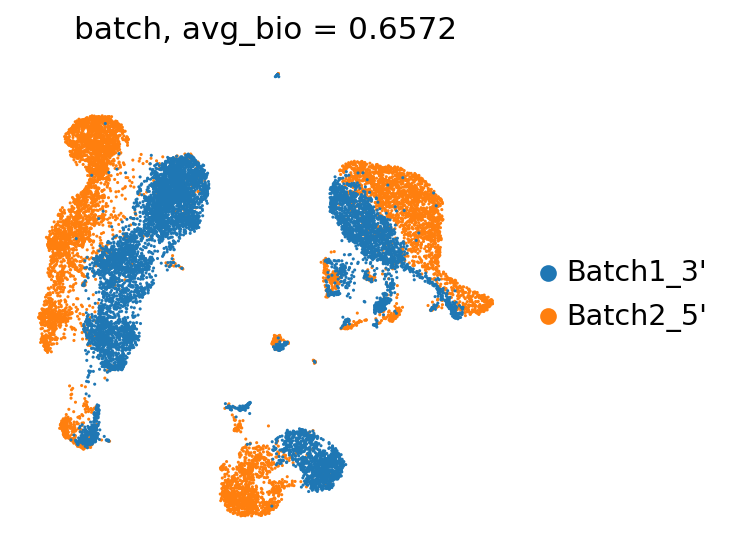

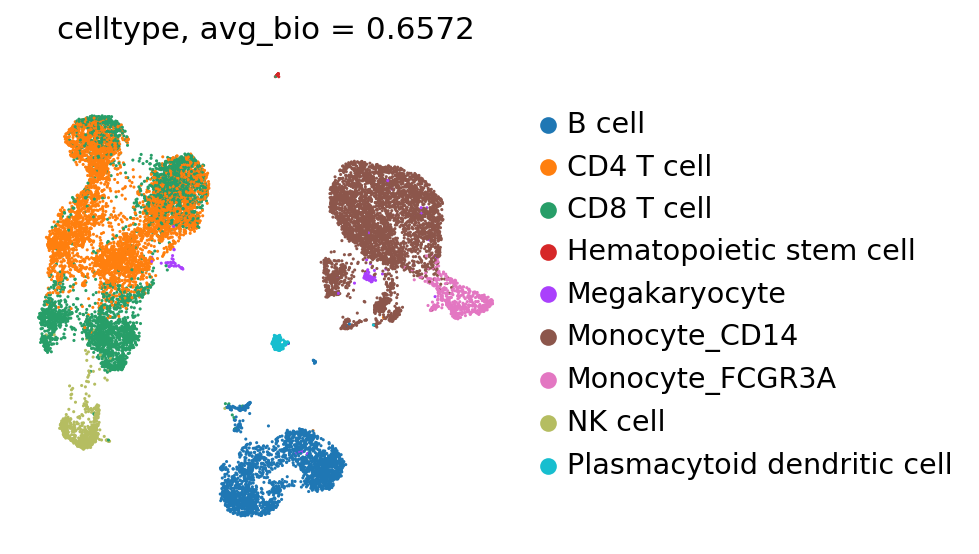

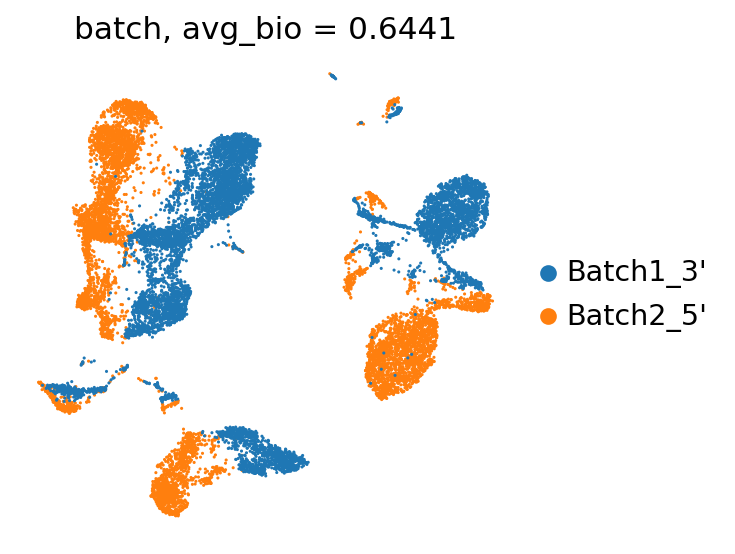

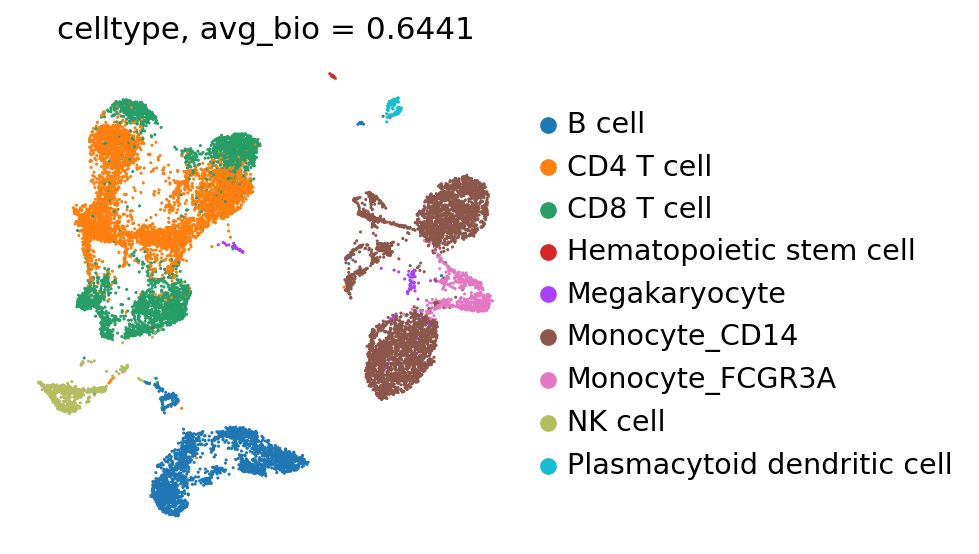

In [89]:
### %%time
best_val_loss = float("inf")
best_avg_bio = 0.0
best_model = None
define_wandb_metrcis()

for epoch in range(1, config.epochs + 1):
    epoch_start_time = time.time()
    train_data_pt, valid_data_pt = prepare_data(sort_seq_batch=per_seq_batch_sample)
    train_loader = prepare_dataloader(
        train_data_pt,
        batch_size=config.batch_size,
        shuffle=True,
        intra_domain_shuffle=True,
        drop_last=False,
    )
    valid_loader = prepare_dataloader(
        valid_data_pt,
        batch_size=config.batch_size,
        shuffle=False,
        intra_domain_shuffle=False,
        drop_last=False,
    )

    if config.do_train:
        train(
            model,
            loader=train_loader,
        )
    val_loss, val_mre = evaluate(
        model,
        loader=valid_loader,
    )
    elapsed = time.time() - epoch_start_time
    logger.info("-" * 89)
    logger.info(
        f"| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | "
        f"valid loss/mse {val_loss:5.4f} | mre {val_mre:5.4f}"
    )
    logger.info("-" * 89)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = copy.deepcopy(model)
        best_model_epoch = epoch
        logger.info(f"Best model with score {best_val_loss:5.4f}")

    if epoch % config.save_eval_interval == 0 or epoch == config.epochs:
        # logger.info(f"Saving model to {save_dir}")
        # torch.save(best_model.state_dict(), save_dir / f"model_e{best_model_epoch}.pt")

        # eval on testdata
        
        adata.obs['batch'] = adata.obs['batch'].astype("category")
        adata.obs['celltype'] = adata.obs['celltype'].astype("category")
        
        results = eval_testdata(
            best_model,
            adata_t=adata_sorted if per_seq_batch_sample else adata,
            include_types=["cls"],
        )
        results["batch_umap"].savefig(
            save_dir / f"embeddings_batch_umap[cls]_e{best_model_epoch}.png", dpi=300
        )

        results["celltype_umap"].savefig(
            save_dir / f"embeddings_celltype_umap[cls]_e{best_model_epoch}.png", dpi=300
        )
        metrics_to_log = {"test/" + k: v for k, v in results.items()}
        metrics_to_log["test/batch_umap"] = wandb.Image(
            str(save_dir / f"embeddings_batch_umap[cls]_e{best_model_epoch}.png"),
            caption=f"celltype avg_bio epoch {best_model_epoch}",
        )

        # metrics_to_log["test/celltype_umap"] = wandb.Image(
        #     str(save_dir / f"embeddings_celltype_umap[cls]_e{best_model_epoch}.png"),
        #     caption=f"celltype avg_bio epoch {best_model_epoch}",
        # )
        # # metrics_to_log["test/best_model_epoch"] = best_model_epoch
        # wandb.log(metrics_to_log)
        # wandb.log({"avg_bio": results.get("avg_bio", 0.0)})

    scheduler.step()


# %%
# save the best model
torch.save(best_model.state_dict(), save_dir / "best_model.pt")

# %% [markdown]
# ## Gene embeddings

# %%
artifact = wandb.Artifact(f"best_model", type="model")
glob_str = os.path.join(save_dir, "best_model.pt")
artifact.add_file(glob_str)
run.log_artifact(artifact)

run.finish()
wandb.finish()
gc.collect()

In [90]:
outdict = simulation_data(best_model,
    adata_t=adata_sorted if per_seq_batch_sample else adata,
    include_types=["cls"])

In [91]:
np.array(outdict)[:,1:2001]

array([[11.97 , 14.02 , 14.52 , ..., 14.32 , 12.9  , 16.6  ],
       [12.586, 13.44 , 14.33 , ..., 12.44 ,  9.15 , 16.72 ],
       [12.65 , 14.22 , 15.92 , ..., 11.96 ,  9.23 , 16.72 ],
       ...,
       [12.91 , 14.16 , 15.95 , ..., 13.72 , 12.47 , 16.78 ],
       [12.7  , 13.42 , 15.016, ..., 14.45 , 13.29 , 16.95 ],
       [12.79 , 13.27 , 14.85 , ..., 14.47 , 14.195, 16.73 ]],
      dtype=float16)

In [92]:
adata_new = sc.AnnData(np.array(outdict)[:,1:2001], obs=adata.obs, var = adata.var)

/tmp/ipykernel_2352/1677489237.py:1: FutureWarning: X.dtype being converted to np.float32 from float16. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_new = sc.AnnData(np.array(outdict)[:,1:2001], obs=adata.obs, var = adata.var)


In [93]:
adata_new.write_h5ad("humanpbmc_nobatch_default.h5ad")

In [94]:
sc.pp.scale(adata_new) 
sc.tl.pca(adata_new)
sc.pp.neighbors(adata_new)
sc.tl.umap(adata_new)

/notebooks/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/notebooks/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


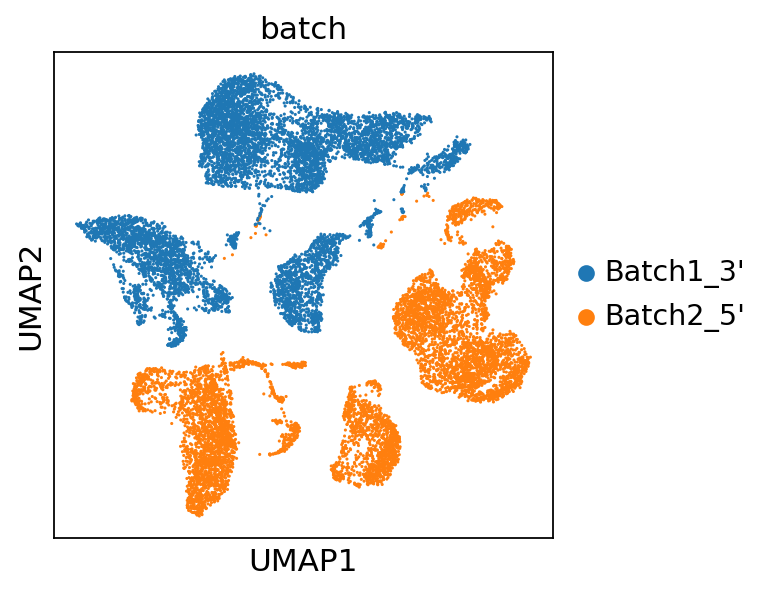

In [95]:
sc.pl.umap(adata_new, color = 'batch')

In [17]:
class Identity(torch.nn.Module):
    def __init__(self, dropout = 0., h_dim = 100, out_dim = 10):
        super(Identity, self).__init__()
        self.conv1 = nn.Conv2d(1, 1, (1, 200))
        self.act = nn.ReLU()
        self.fc1 = nn.Linear(in_features=SEQ_LEN, out_features=512, bias=True)
        self.act1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(in_features=512, out_features=h_dim, bias=True)
        self.act2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        self.fc3 = nn.Linear(in_features=h_dim, out_features=out_dim, bias=True)

    def forward(self, x):
        x = x[:,None,:,:]
        x = self.conv1(x)
        x = self.act(x)
        x = x.view(x.shape[0],-1)
        x = self.fc1(x)
        x = self.act1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

In [ ]:
# test zero-shot
# best_model = model

In [ ]:
# results = return_testdata(
#     best_model,
#     adata_t=adata_sorted if per_seq_batch_sample else adata,
#     include_types=["cls"],
# )

In [ ]:
adata.obs['celltype'] = adata.obs['celltype'].astype('category')

In [21]:
# best_model = model

scGPT - INFO - Evaluating cls cell embeddings


100%|██████████| 1048/1048 [02:13<00:00,  7.82it/s]


NMI...
ARI...
Silhouette score...
PC regression...
Graph connectivity...
scGPT - INFO -                                   0
NMI_cluster/label          0.680040
ARI_cluster/label          0.433877
ASW_label                  0.586007
ASW_label/batch            0.808779
PCR_batch                  0.754719
cell_cycle_conservation         NaN
isolated_label_F1               NaN
isolated_label_silhouette       NaN
graph_conn                 0.908025
kBET                            NaN
iLISI                           NaN
cLISI                           NaN
hvg_overlap                     NaN
trajectory                      NaN
scGPT - INFO - Biological Conservation Metrics: 
ASW (cell-type): 0.5860, graph cLISI: nan, isolated label silhouette: nan, 
Batch Effect Removal Metrics: 
PCR_batch: 0.7547, ASW (batch): 0.8088, graph connectivity: 0.9080, graph iLISI: nan


/notebooks/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/notebooks/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/notebooks/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/notebooks/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 

Error: You must call wandb.init() before wandb.log()

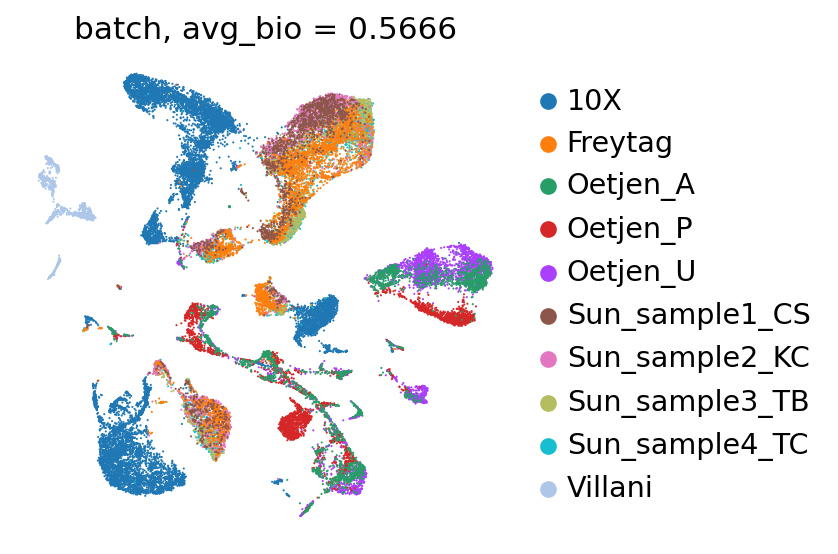

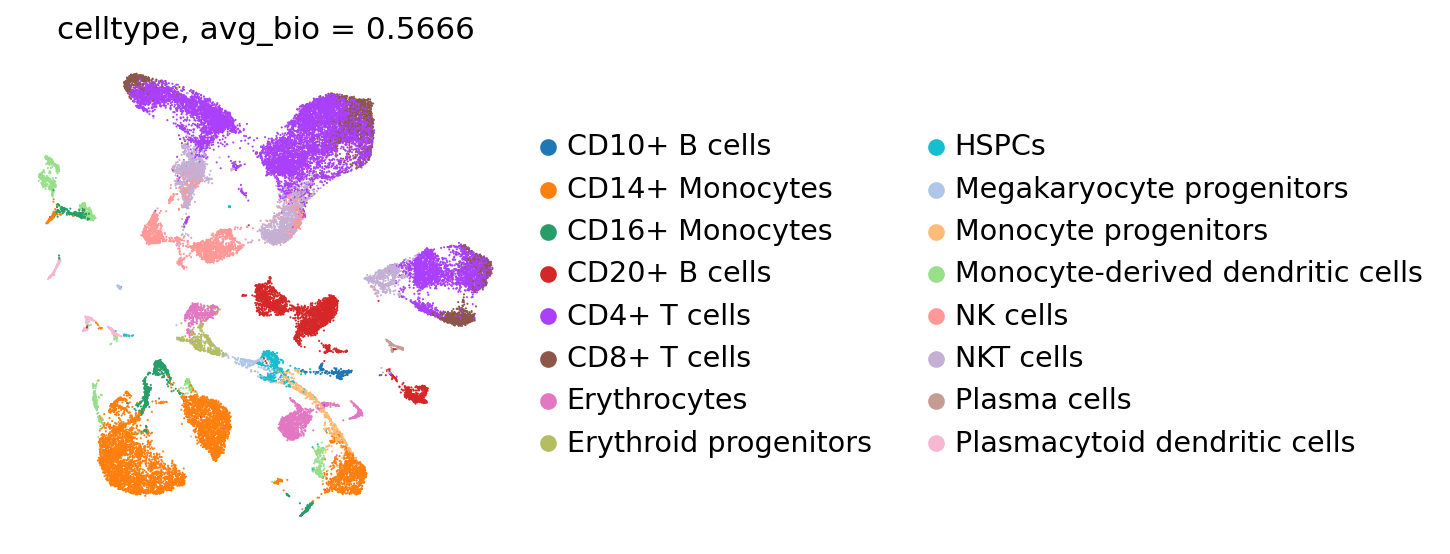

In [22]:
# eval on testdata
results = eval_testdata(
    best_model,
    adata_t=adata_sorted if per_seq_batch_sample else adata,
    include_types=["cls"],
)
results["batch_umap"].savefig(
    save_dir / f"embeddings_batch_umap[cls]_e{best_model_epoch}.png", dpi=300
)

results["celltype_umap"].savefig(
    save_dir / f"embeddings_celltype_umap[cls]_e{best_model_epoch}.png", dpi=300
)
metrics_to_log = {"test/" + k: v for k, v in results.items()}
metrics_to_log["test/batch_umap"] = wandb.Image(
    str(save_dir / f"embeddings_batch_umap[cls]_e{best_model_epoch}.png"),
    caption=f"celltype avg_bio epoch {best_model_epoch}",
)

metrics_to_log["test/celltype_umap"] = wandb.Image(
    str(save_dir / f"embeddings_celltype_umap[cls]_e{best_model_epoch}.png"),
    caption=f"celltype avg_bio epoch {best_model_epoch}",
)
metrics_to_log["test/best_model_epoch"] = best_model_epoch
wandb.log(metrics_to_log)
wandb.log({"avg_bio": results.get("avg_bio", 0.0)})